In [15]:
import mlflow, numpy as np, tempfile, boto3, os, pickle, xarray as xr
from matplotlib import pyplot as plt
from jax import vmap
mlflow.set_tracking_uri("https://continuum.ergodic.io/experiments/")
s3 = boto3.client("s3")

In [10]:
exp = mlflow.get_experiment_by_name("opt-64lines")
un_exp = mlflow.get_experiment_by_name("uniform-64lines")
avg_exp = mlflow.get_experiment_by_name("optavg-64lines")
random_phase_exp = mlflow.get_experiment_by_name("randomphaser-64lines")


In [11]:
# filter runs with "temperature" in the mlflow run name
runs = mlflow.search_runs(experiment_names=[exp.name], filter_string="attribute.run_name LIKE '%temperature%'")
un_runs = mlflow.search_runs(experiment_names=[un_exp.name], filter_string="attribute.run_name LIKE '%temperature%'")
avg_runs = mlflow.search_runs(experiment_names=[avg_exp.name], filter_string="attribute.run_name LIKE '%temperature%'")
random_phase_runs = mlflow.search_runs(experiment_names=[random_phase_exp.name], filter_string="attribute.run_name LIKE '%temperature%'")

In [6]:
stored_loss_for_nan = runs.iloc[1]["metrics.loss"]
stored_loss_for_bigval = runs.iloc[0]["metrics.loss"]

In [7]:
# get temperatures, intensities, gsls " eV", " W/cm^2", " um"
runs = runs[2:-2]
make_arr = lambda col_of_int, substring: np.array([float(val.strip(substring)) for val in col_of_int])
temperatures = make_arr(runs["params.units.reference electron temperature"].unique(), "eV")
intensities = make_arr(runs["params.units.laser intensity"].unique(), "W/cm^2")
gsls = make_arr(runs["params.density.gradient scale length"].unique(), "um")

temperatures.sort(), intensities.sort(), gsls.sort()

(None, None, None)

In [8]:
loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
un_loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
avg_loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
random_phase_loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
amplitudes = np.zeros((len(temperatures), len(intensities), len(gsls), 64))
phases = np.zeros((len(temperatures), len(intensities), len(gsls), 64))

s3 = boto3.client("s3")

with tempfile.TemporaryDirectory() as td:
    for i, temp in enumerate(temperatures):
        for j, intensity in enumerate(intensities):
            for k, gsl in enumerate(gsls):
                run = runs[(runs["params.units.reference electron temperature"] == f"{temp} eV") & 
                        (runs["params.units.laser intensity"] == f"{intensity} W/cm^2") & 
                        (runs["params.density.gradient scale length"] == f"{gsl} um")]
                

                # if (temp == 2000) and (intensity == 4e14) and (gsl == 1400/3):
                #     print(run) 
                #     print(run["metrics.loss"])
                # loss_values[i, j, k] = run["metrics.loss"].values[0]    
                loc_dict = {"temperature": temp, "intensity": intensity, "gsl": gsl}
                loss_values.loc[loc_dict] = run["metrics.loss"].values[0]

                un_run = un_runs[(un_runs["params.units.reference electron temperature"] == f"{temp} eV") &
                                (un_runs["params.units.laser intensity"] == f"{intensity} W/cm^2") &
                                (un_runs["params.density.gradient scale length"] == f"{gsl} um")]
                un_loss_values.loc[loc_dict] = un_run["metrics.loss"].values[0]

                avg_run = avg_runs[(avg_runs["params.units.reference electron temperature"] == f"{temp} eV") &
                                (avg_runs["params.units.laser intensity"] == f"{intensity} W/cm^2") &
                                (avg_runs["params.density.gradient scale length"] == f"{gsl} um")]      
                avg_loss_values.loc[loc_dict] = np.mean(avg_run["metrics.loss"].dropna().values)#[0]

                random_phase_run = random_phase_runs[(random_phase_runs["params.units.reference electron temperature"] == f"{temp} eV") &
                                (random_phase_runs["params.units.laser intensity"] == f"{intensity} W/cm^2") &
                                (random_phase_runs["params.density.gradient scale length"] == f"{gsl} um")]
                # print(loc_dict)
                random_phase_loss_values.loc[loc_dict] = random_phase_run["metrics.loss"].values[0]

loss_values.loc[{"temperature": 3500, "intensity": 4e14, "gsl": 600}] = stored_loss_for_nan
loss_values.loc[{"temperature": 2000, "intensity": 7e14}][1] = stored_loss_for_bigval


## Download Drivers

In [2]:
# optimal_bw = xr.Dataset({"amplitudes": amplitudes_xr, "phases": phases_xr})
optimal_bw = xr.open_dataset("../results/optimal_bw.nc")

In [ ]:
from adept import ergoExo
from ml4tpd.module import TPDModule
import yaml

ImportError: attempted relative import with no known parent package

In [13]:
nc = 64
un_nc = 8
this_temp = 2000
this_int = 4e14
this_gsl = 600

nt = 512
num_phases = 16



loc_dict = {"temperature": this_temp, "intensity": this_int, "gsl": this_gsl}
amplitudes = optimal_bw["amplitudes"].loc[loc_dict].values
phases = optimal_bw["phases"].loc[loc_dict].values
un_dw = np.linspace(-0.015, 0.015, un_nc)

light_wave = {"delta_omega": optimal_bw.coords["delta_omega"], "phases": phases, "intensities": amplitudes} 
un_light_wave = [{"delta_omega": un_dw, "phases": np.random.uniform(-np.pi, np.pi, un_nc), "intensities": np.ones(un_nc)/un_nc} for _ in range(num_phases)]

In [17]:
from tqdm import tqdm
import yaml

# get config 
parent_runs = runs[runs["params.density.gradient scale length"] == f"{this_gsl:.1f} um"]
artifact_path = parent_runs["artifact_uri"].values[0]
artifact_path += "/config.yaml"
s3.download_file("public-ergodic-continuum", artifact_path[30:], "./config.yaml")
with open("./config.yaml", "r") as fi:
    config = yaml.safe_load(fi)

exo = ergoExo()
modules = exo._setup_(config, None, TPDModule, log=False)

nx = config["grid"]["nx"]
tmin, tmax = 4, 5

tax = np.linspace(tmin, tmax, nt)
y = exo.adept_module.state
e0_vs_t = np.zeros((nt, nx), dtype=np.complex64)
une0_vs_t = np.zeros((nt, nx, num_phases), dtype=np.complex64)

from jax import jit
@jit
def get_one_xprofile(_t, _y, _light_wave):
    return exo.adept_module.diffeqsolve_quants["terms"].vector_field.light.laser_update(_t, _y, _light_wave)[:, 0, 1]


for i, t in enumerate(tax):
    e0_vs_t[i] = get_one_xprofile(t, y, light_wave)
    for j in range(num_phases):
        une0_vs_t[i, :, j] = get_one_xprofile(t, y, un_light_wave[j])
    

dt = tax[1]-tax[0]
w0_xt = np.gradient(np.unwrap(np.angle(e0_vs_t), axis=0), axis=0)/dt
un_w0_xt = np.gradient(np.unwrap(np.angle(np.mean(une0_vs_t, axis=-1)), axis=0), axis=0)/dt

NameError: name 'TPDModule' is not defined

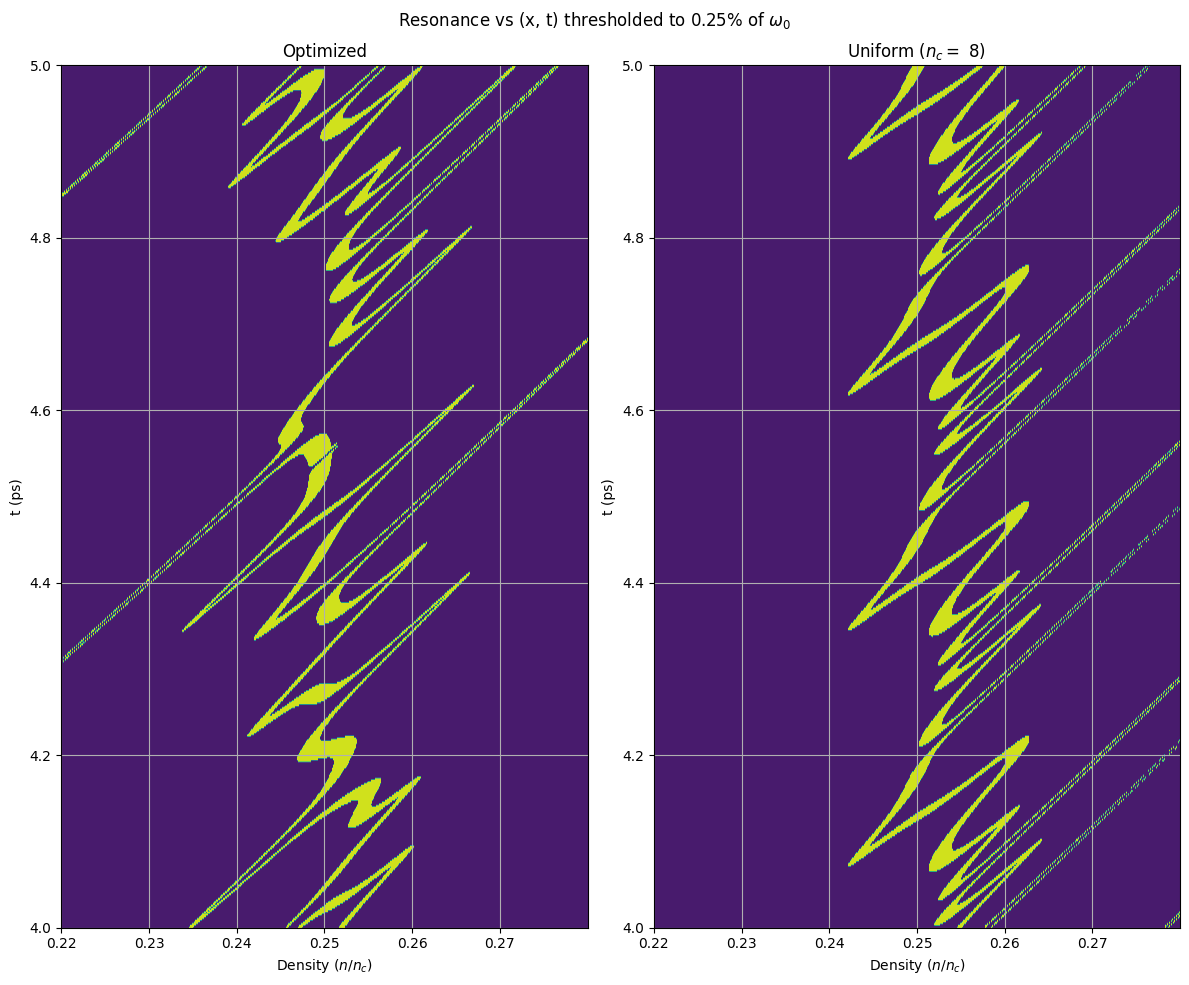

In [213]:
density = y["background_density"][:, 0]
nmin, nmax = 0.22, 0.28

clevs = np.linspace(-2, 2, 10)

density_slice = slice(np.argmin(np.abs(density-nmin)), np.argmin(np.abs(density-nmax)))
w0 = 5366.528681791605
wp0 = 2683.2643408958024
wp = np.sqrt(density/0.25)*wp0
opt_match = w0 - w0_xt - 2*wp
opt_match = opt_match[:, density_slice]
opt_match /= w0/100
threshold_percent = 0.25
opt_match = np.where(np.abs(opt_match) < threshold_percent, 1, 0)

uniform_match = w0 - un_w0_xt - 2*wp
uniform_match = uniform_match[:, density_slice]
uniform_match /= w0/100
uniform_match = np.where(np.abs(uniform_match) < threshold_percent, 1, 0)

fig, ax = plt.subplots(1, 2, figsize=(12, 10), tight_layout=True)
c = ax[0].contourf(density[density_slice], tax, opt_match) #, levels=clevs, cmap="coolwarm")
ax[0].set_title("Optimized")
ax[0].set_xlabel("Density $(n/n_c)$")
ax[0].set_ylabel("t (ps)")
fig.suptitle("Resonance vs (x, t) thresholded to $0.25\%$ of $\omega_0$")
# ax[0].set_ylim(tmin, tmax)
ax[0].grid()
# fig.colorbar(c)
c = ax[1].contourf(density[density_slice], tax, uniform_match) #, levels=clevs, cmap="coolwarm")
ax[1].set_xlabel("Density $(n/n_c)$")
ax[1].set_ylabel("t (ps)")
# ax[1].set_ylim(tmin, tmax)
ax[1].set_title(f"Uniform ($n_c = $ {un_nc})")
ax[1].grid()
# fig.colorbar(c)

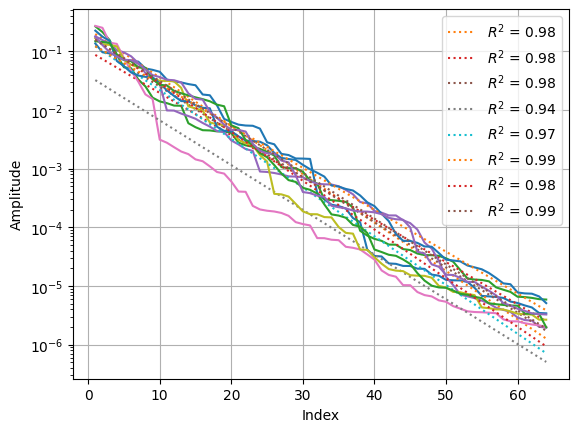

In [229]:
amp_inds = np.arange(64)+1
for _ in range(8):
    temp = np.random.choice(temperatures)
    intensity = np.random.choice(intensities)
    gsl = np.random.choice(gsls)
    loc_dict = {"temperature": temp, "intensity": intensity, "gsl": gsl}
    sorted_amps = np.sort(optimal_bw["amplitudes"].loc[loc_dict])[::-1]
    # slope, intercept, r_value, _, _ = linregress(np.log(amp_inds), np.log(sorted_amps))
    slope, intercept, r_value, _, _ = linregress(amp_inds, np.log(sorted_amps))
    plt.semilogy(amp_inds, sorted_amps)
    # plt.semilogy(amp_inds, np.exp(intercept)*amp_inds**slope, ":" ,label=f"$R^2$ = {r_value**2:.2f}")    
    plt.semilogy(amp_inds, np.exp(intercept)*np.exp(slope*amp_inds), ":", label=f"$R^2$ = {r_value**2:.2f}")

plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
from scipy.stats import linregress



np.float64(-3.208801866797209)